In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [2]:
np.random.seed(42)
n_samples = 100_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + np.cos( 3 * x2 ) + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [3]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [4.5, 5, 5.5, 6, 6.5, 7, 7.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [4]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [5]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [6]:
from quantbullet.linear_product_model import LinearProductRegressorBCD

lpm_ols = LinearProductRegressorBCD()

In [7]:
lpm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, Loss: 1.0121
Iteration 2/10, Loss: 1.0122
Iteration 3/10, Loss: 1.0122
Iteration 4/10, Loss: 1.0122
Iteration 5/10, Loss: 1.0122
Iteration 6/10, Loss: 1.0122
Early stopping at iteration 6 with Loss: 1.0122


In [8]:
df['model_predict'] = lpm_ols.predict(train_df)

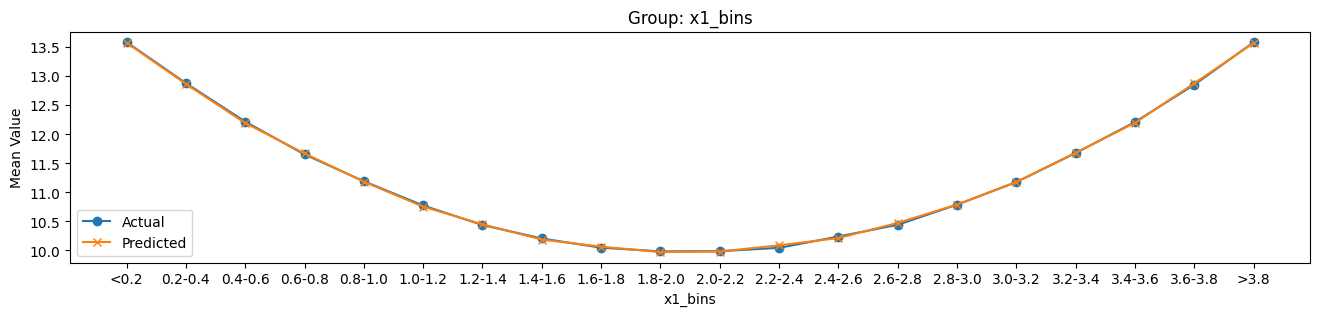

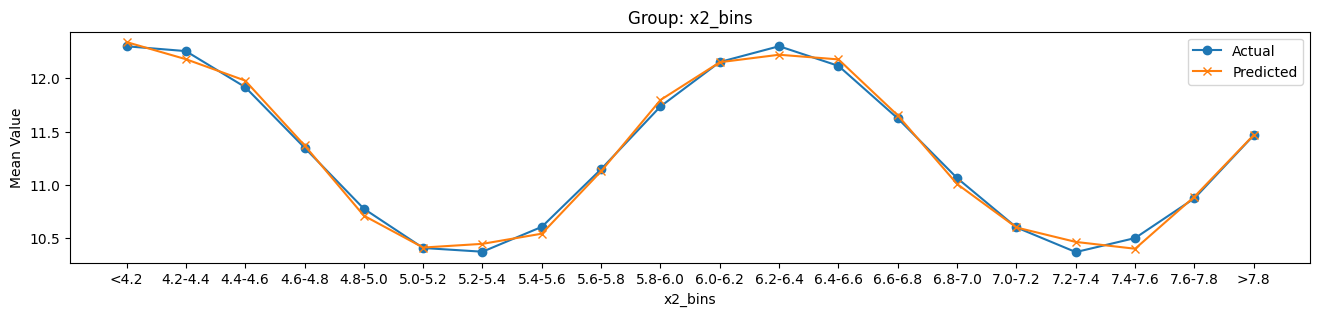

In [9]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Using Cross-Entropy Loss

In [10]:
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

np.float64(0.06797)

In [11]:
from quantbullet.linear_product_model import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-10, gtol=1e-10, eps=1e-3)

In [12]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Using initial params: {'x1': array([0.00635442, 0.00297863, 0.0057577 , 0.00853636, 0.01131895,
       0.01409858, 0.01687646, 0.01965575, 0.02243526]), 'x2': array([0.00087751, 0.00392167, 0.0043057 , 0.00468994, 0.00507391,
       0.00545783, 0.00584162, 0.00622546, 0.00660896])}
Iter 1: 24439.892100114743
Iter 2: 23630.652133810676
Iter 3: 22628.213136544276
Iter 4: 22603.623562107503
Iter 5: 22559.287828372686
Iter 6: 22513.181409577417
Iter 7: 22450.757408788933
Iter 8: 22336.321833569193
Iter 9: 22104.662376810862
Iter 10: 22006.414784361263
Iter 11: 21927.516164615423
Iter 12: 21906.027134729047
Iter 13: 21898.598264453736
Iter 14: 21896.013293406788
Iter 15: 21893.78938517605
Iter 16: 21875.13615861142
Iter 17: 21848.09052677327
Iter 18: 21813.575329571977
Iter 19: 21784.970175029142
Iter 20: 21755.786217098983
Iter 21: 21754.824800466202
Iter 22: 21754.41116475427
Iter 23: 21753.041580851677
Iter 24: 21749.709326539745
Iter 25: 21741.489693374624
Iter 26: 21725.698458318177
It

In [13]:
lpc_scipy.coef_

array([-5.65996588, -1.6366957 , -0.46819394, -0.10243668, -0.01660242,
        0.02049306,  0.10836249,  0.47059245,  1.5608425 ,  1.20837048,
       -0.25212518, -0.49319144,  0.04660715,  0.49826747,  0.06485204,
       -0.5897218 , -0.056836  ,  0.44819228])

In [14]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

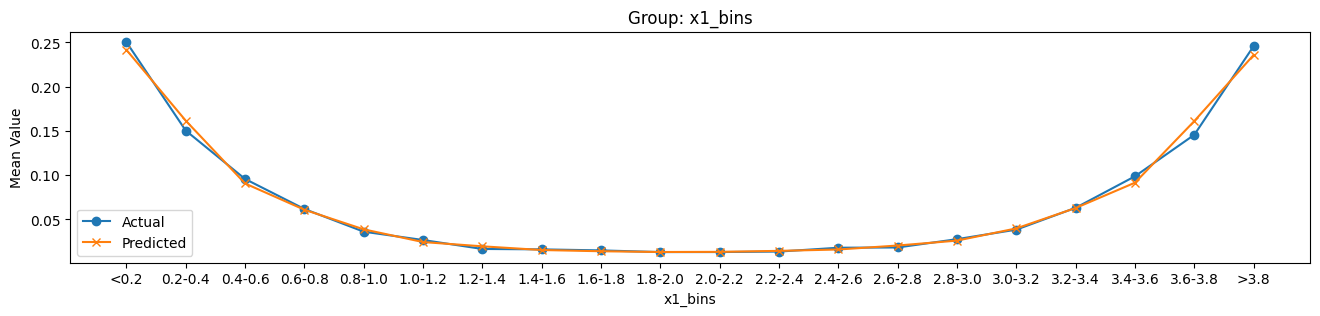

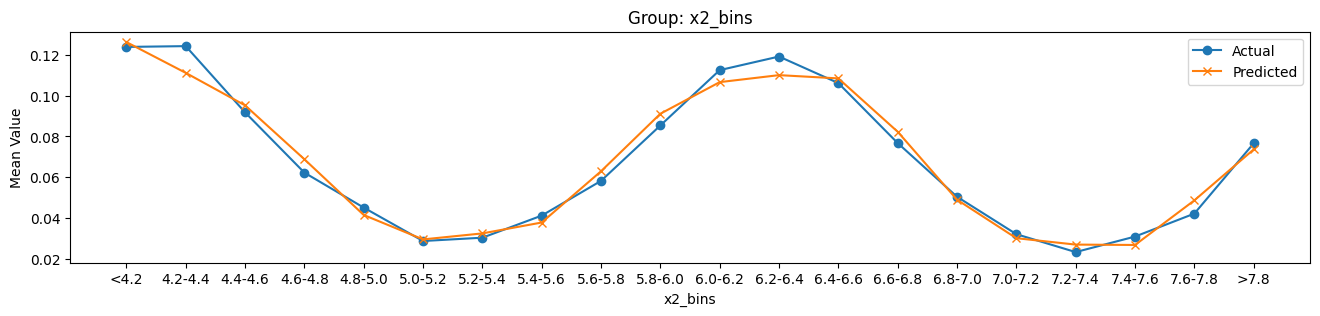

In [15]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Minimizing MSE, use OLS for Classification

In [16]:
probs = 1 / (1 + np.exp(-(df['y'] - 16)))
df['binary_y'] = np.random.binomial(1, probs)
print(df['binary_y'].mean())

0.03221


In [17]:
from quantbullet.linear_product_model import LinearProductRegressorBCD, LinearProductRegressorScipy

lprm_ols = LinearProductRegressorBCD()

In [18]:
lprm_ols.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, Loss: 0.0289
Iteration 2/10, Loss: 0.0289
Iteration 3/10, Loss: 0.0289
Iteration 4/10, Loss: 0.0289
Iteration 5/10, Loss: 0.0289
Iteration 6/10, Loss: 0.0289
Iteration 7/10, Loss: 0.0289
Iteration 8/10, Loss: 0.0289
Iteration 9/10, Loss: 0.0289
Iteration 10/10, Loss: 0.0289


In [19]:
lprm_ols.coef_dict

{'x1': {'x1_bias': np.float64(-23.839858629547162),
  'x1_le_0.5': np.float64(-8.511400063247327),
  'x1_0.5_1.0': np.float64(-0.9679883776042911),
  'x1_1.0_1.5': np.float64(-0.44187405675758207),
  'x1_1.5_2.0': np.float64(-0.14787600758104966),
  'x1_2.0_2.5': np.float64(0.12676645385385754),
  'x1_2.5_3.0': np.float64(0.4002446996247962),
  'x1_3.0_3.5': np.float64(1.2151033409860963),
  'x1_gt_3.5': np.float64(7.2113563145106605)},
 'x2': {'x2_bias': np.float64(6.642479827730524),
  'x2_le_4.5': np.float64(-1.526053396673981),
  'x2_4.5_5.0': np.float64(-2.4706757433807627),
  'x2_5.0_5.5': np.float64(0.07261126287944385),
  'x2_5.5_6.0': np.float64(2.3138238647499874),
  'x2_6.0_6.5': np.float64(0.876355369839354),
  'x2_6.5_7.0': np.float64(-3.1771737647930705),
  'x2_7.0_7.5': np.float64(-0.001880936144301172),
  'x2_gt_7.5': np.float64(2.024404907399682)}}

In [20]:
df['model_predict_BCD'] = lprm_ols.predict(train_df)

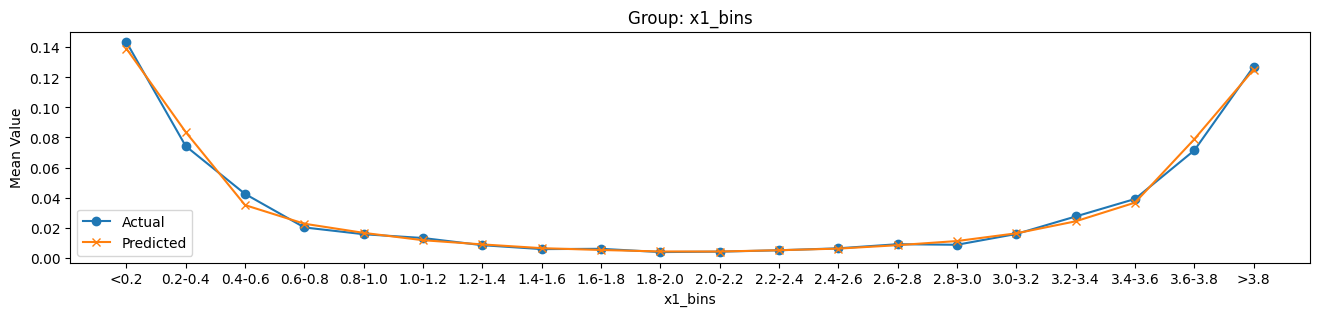

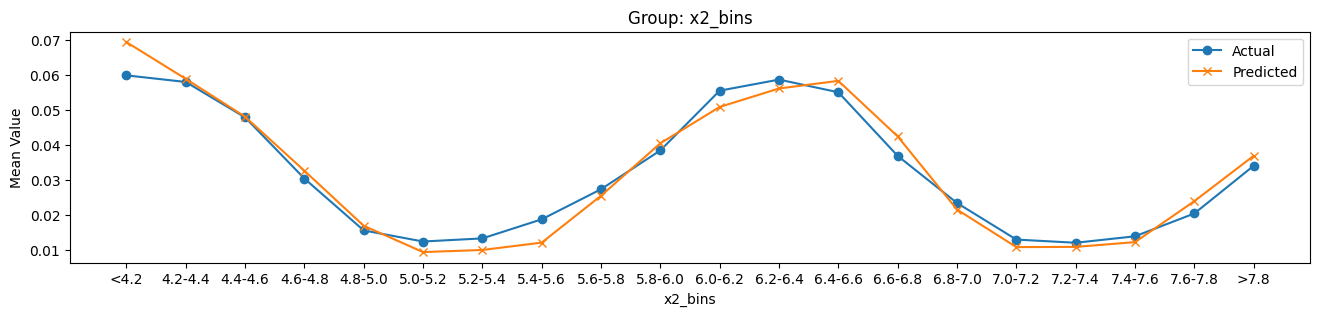

In [21]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [22]:
lpm_scipy = LinearProductRegressorScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lpm_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4870e+10                                    1.44e+10    
       1              2         8.7853e+09      2.61e+10       4.24e+00       7.35e+09    
       2              4         2.4219e+07      8.76e+09       1.06e+00       3.65e+08    
       3              5         1.4511e+06      2.28e+07       2.12e+00       3.79e+07    
       4              7         9.1621e+04      1.36e+06       1.06e+00       5.13e+06    
       5              9         7.1050e+03      8.45e+04       5.30e-01       5.19e+05    
       6             11         1.7969e+03      5.31e+03       2.65e-01       2.33e+04    
       7             13         1.5240e+03      2.73e+02       1.33e-01       2.43e+03    
       8             15         1.5141e+03      9.91e+00       6.63e-02       1.32e+03    
       9             16         1.4886e+03      2.55e+01       6.63e-02       8.31e+01    

In [23]:
df['model_predict'] = lpm_scipy.predict(train_df)

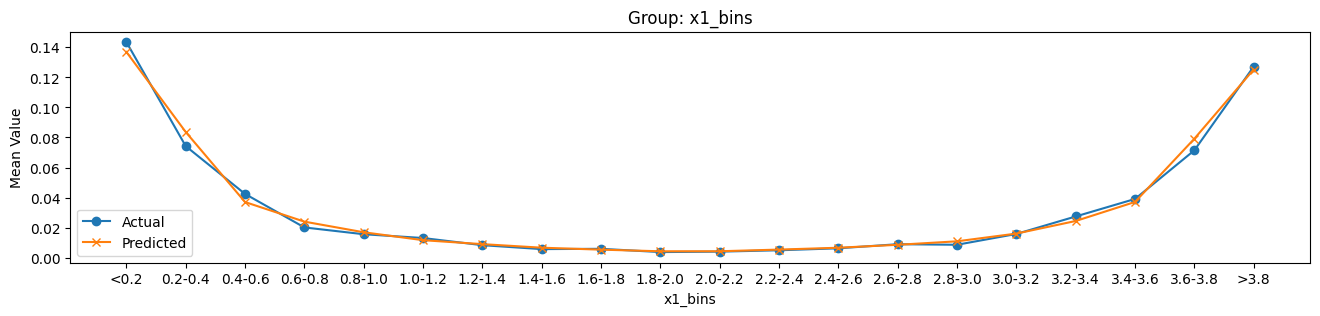

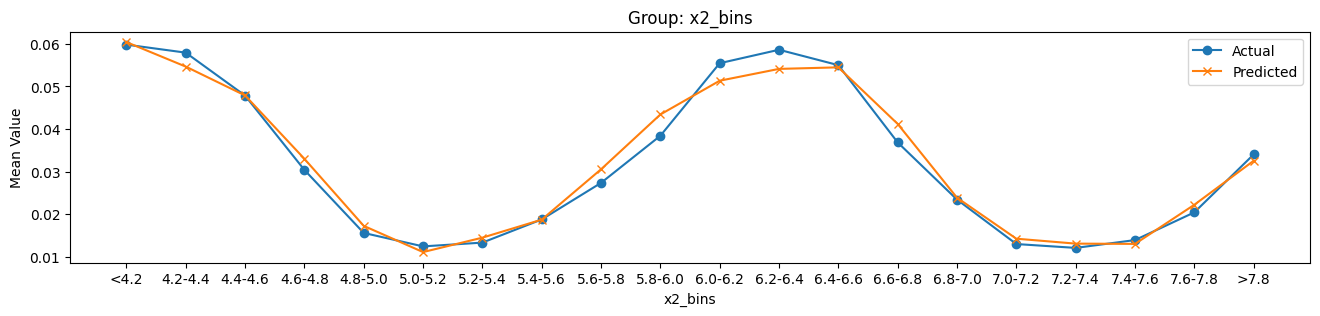

In [24]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [25]:
# import the mse function
from sklearn.metrics import mean_squared_error
mse_bcd = mean_squared_error(df['binary_y'], df['model_predict_BCD'])
print(f'MSE (Alternating Coordinate Descent + OLS): {mse_bcd:.4f}')
mse_scipy = mean_squared_error(df['binary_y'], df['model_predict'])
print(f'MSE (Scipy Optimization): {mse_scipy:.4f}')

MSE (Alternating Coordinate Descent + OLS): 0.0289
MSE (Scipy Optimization): 0.0288
